# INM705 Coursework
# Neural Style Transfer - Using ResNet50

In [1]:
import os,sys,re
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor

#from utils import get_content_cost_one_layer, get_content_cost, get_style_cost_one_layer,get_style_cost
# choose which model to use
# device
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

print("Working on " + str(device).upper())
from sklearn.metrics import ConfusionMatrixDisplay

Working on CUDA


In [2]:


def get_content_cost_one_layer(content_img_feature, generated_img_feature):
    """
    This function only considers one layer only.
    """
    _,channels, height, width  = content_img_feature.size()

    #print(f'{height} {width} {channels}')
    
    #we need to iterate on the spatial region of images (height x width) across three channels:
    content_spatial = content_img_feature.view((channels, height*width))
    generated_spatial = generated_img_feature.view((channels, height*width))
    
    element_wise_diff = torch.subtract(content_spatial, generated_spatial)
    squared_diff = torch.square(element_wise_diff)
    
    factor = 1/(4*channels*width*height)
    content_cost = factor*torch.sum(squared_diff)
    return content_cost
#get_content_cost(content_img, generated_img)

def get_content_cost(content_img_op, generated_img_op, use_all_layers = False):
    cost = 0
    if use_all_layers:
        #iterating on all the features cooresponding to our choosen layers:
        for content_img_feature, generated_img_feature in zip(content_img_op[:-1], generated_img_op[:-1]):
            cost += get_content_cost_one_layer(content_img_feature, generated_img_feature)
    else:
        cost += get_content_cost_one_layer(content_img_op[-1], generated_img_op[-1])
        
    return cost


def get_style_cost_one_layer(style_img_l, generate_img_l):
    
    #getting dimensions from the activation layer input:
    _,channels, height, width = style_img_l.size()
    
    #resizing the tensors to infold along height and width:
    style_img_l = style_img_l.view((channels, height*width))
    generate_img_l = generate_img_l.view((channels, height*width))

    # print('checking.....', style_img_l)
    #calculating the gram matrices:
    gram_style = style_img_l.mm(style_img_l.t())
    #torch.linalg.matmul(style_img_l, torch.transpose(style_img_l,0,1))
    gram_generate = generate_img_l.mm(generate_img_l.t())
    #torch.linalg.matmul(generate_img_l, torch.transpose(generate_img_l,0,1))
    
    #calculating the cost:
    gram_difference = torch.subtract(gram_style,gram_generate)
    gram_diff_squared = torch.square(gram_difference)
    
    #defining the factor:
    factor = 1/(2*channels*height*width)
    
    return factor*factor*torch.sum(gram_diff_squared)
    
    
def get_style_cost(style_img_op, generated_img_op, style_layers,use_all_layers=False):
    #if not use_all_layers:
    style_img_op = style_img_op[:-1]
    generated_img_op = generated_img_op[:-1]
    layers = style_layers
        
    cost = 0
    for i,layer in zip(range(len(style_img_op)),layers):
        # print(i,layer)
        # print(layers[layer])
        weight_factor = layers[layer]
        temp = get_style_cost_one_layer(style_img_op[i], generated_img_op[i])
        
        cost += weight_factor*temp
        
        
    return cost


### Loading ResNet50

In [3]:
resNet = torchvision.models.resnet50(pretrained=True)

In [4]:
#setting traninable to False for all the layers
for param in resNet.parameters():
    param.requires_grad = False
    

In [5]:
style_layers = {}
content_layers = {}

style_layers['2'] = 0.2
style_layers['31'] = 0.2
style_layers['59'] = 0.2
style_layers['101'] = 0.2
style_layers['115'] = 0.2


content_layers['115'] = 1

print(style_layers)
print(content_layers)

chosen_layers = {**style_layers, **content_layers}
print(chosen_layers)

{'2': 0.2, '31': 0.2, '59': 0.2, '101': 0.2, '115': 0.2}
{'115': 1}
{'2': 0.2, '31': 0.2, '59': 0.2, '101': 0.2, '115': 1}


In [6]:


class Resnet50(torch.nn.Module):
    chosen_layers = {**style_layers , **content_layers}
    def __init__(self):
        super(Resnet50, self).__init__()
        
        resNet = torchvision.models.resnet50(pretrained=True)
        # for param in resNet.parameters():
        #     param.requires_grad = False
            
        self.all_layers = []
        
        for child in resNet.children():
            if type(child) == nn.Sequential:
                for grand_child in child.children():
                    layers = self.iterate_children(grand_child)
                    self.all_layers.extend(layers)

            else:
                self.all_layers.append(child)
                
        #print(self.all_layers)
        self.all_layers = self.all_layers[:-2]
        for i in range(len(self.all_layers)):
            self.all_layers[i] = self.all_layers[i].to(device)


        
    def iterate_children(self, block):
        layers = []
        for child in block.children():
            if type(child) == nn.Sequential:
                # for grand_child in child.children():
                #     layers.append(grand_child)
                continue
            else:
                layers.append(child)

        return layers

    def forward(self,x):
        chosen_layers_outputs = []
        
        for i,weights in enumerate(self.all_layers):
            #print(self.chosen_layers)
            #pass x through the x layer
            x = weights(x)
            #print(i, weights)
            if str(i) in self.chosen_layers:
                chosen_layers_outputs.append(x)
          
        return chosen_layers_outputs

### Final Cost

In [7]:
def get_total_cost(alpha, beta, content_cost, style_cost):
    # content_cost = get_content_cost(content_img, generated_img)
    # style_cost = get_style_cos(style_img, generated_img)
    return alpha*content_cost + beta*style_cost

### Loading the Images

In [8]:
def plotTensorImg(img_tensor):
    # img_tensor.cpu()
    _,c,h,w = img_tensor.size()
    img_tensor = np.array(img_tensor.detach().cpu(), dtype=np.uint8)
    
    if np.ndim(img_tensor) > 3:
        assert img_tensor.shape[0] == 1
        img_tensor = img_tensor[0]
        print(f'New shape : {img_tensor.shape}')
        img_tensor = img_tensor.reshape((h,w,c))
        img = Image.fromarray(img_tensor)
        plt.imshow(img)
        
    return

In [9]:
def load_content_img(path,show=False):
    #this function return the tensor of content image:
    content_img = Image.open(path)
    if show:
        plt.imshow(content_img)
        plt.show()
        print(f'Original size of imsage : {content_img.size}')
        
    content_img = transform(content_img).unsqueeze(0)
    
    if show:
        
        temp = transforms.functional.to_pil_image(content_img.squeeze(0))
        plt.imshow(temp)
        plt.title('Resized')
        plt.show()
        print(f'Transfomed size of imsage : {temp.size}')
        
    return content_img.to(device,dtype=torch.float32)

def load_style_img(path, show=False):
    #this function return the tensor of 
    style_img = Image.open(path)
    if show:
        plt.imshow(style_img)
        plt.title('Orignal')
        plt.show()
        print(f'Original size of imsage : {style_img.size}')
        
    style_img = transform(style_img).unsqueeze(0)
    
    if show:
        
        temp = transforms.functional.to_pil_image(style_img.squeeze(0))
        plt.imshow(temp)
        plt.title('Resized')
        plt.show()
        print(f'Original size of imsage : {temp.size}')
        
    return style_img.to(device,dtype=torch.float32)
    

def load_generated_img(path, show=False):
    content_img = load_content_img(path)
    # noise = torch.randn(content_img.size(),).to(device)
    # generated_img = content_img + noise
    return content_img.clone()
    # return generated_img

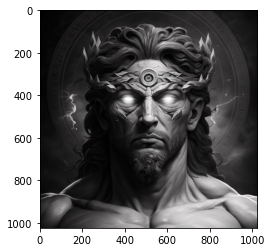

Original size of imsage : (1024, 1024)


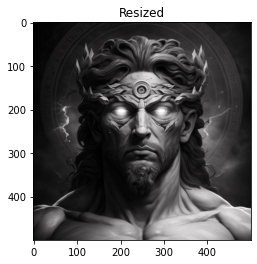

Transfomed size of imsage : (500, 500)


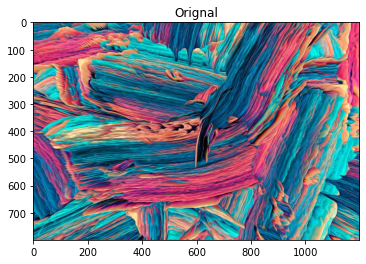

Original size of imsage : (1200, 800)


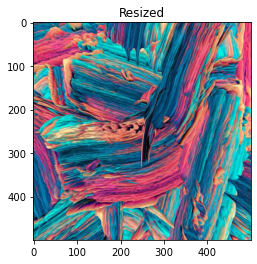

Original size of imsage : (500, 500)


In [10]:
img_size = 500

transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
    ]
)

content_img = load_content_img('Contents/2.jpg',show=True)
style_img = load_style_img('Styles/5.jpg',show=True)
generated_img = load_generated_img('Contents/2.jpg',show=True).requires_grad_(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3000 || Cost : 0.0005737433675676584


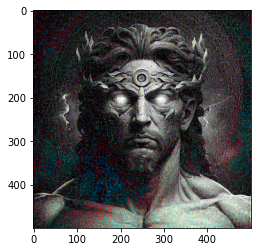

KeyboardInterrupt: 

In [11]:
#defining Hyperparameters:
epochs = 15000
learning_rate = 0.01
alpha = 10
beta = 30

cost_history = []
#setting up the Adam Optmizer
optimizer = torch.optim.Adam([generated_img], learning_rate)

#creating model
model = Resnet50().to(device)
model.eval()

for e in range(1,epochs+1):
    # print(f'Epoch number {e}')
    content_img_op = model(content_img)
    style_img_op = model(style_img)
    generated_img_op = model(generated_img)
    

    
    content_cost = get_content_cost(content_img_op, generated_img_op, use_all_layers=False)
    style_cost = get_style_cost(style_img_op, generated_img_op, style_layers, use_all_layers=False)
    # print(content_cost, style_cost)
    total_cost = get_total_cost(alpha, beta, content_cost, style_cost)
    
    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()
    
    if e%500 == 0:
        cost_history.append(total_cost.item())
    if e%3000 == 0:
        print(f'Epoch : {e} || Cost : {total_cost.item()}')
        save_image(generated_img,f'op{e}.png')
        op = generated_img.clone().detach().cpu()
        op = op.view((generated_img.size(1), generated_img.size(2), generated_img.size(3)))
        # op = op.to(dtype=torch.uint8)
        # print(op.size())
        plt.imshow(op.permute(1,2,0))
        plt.show()
    
    
    
#2, 31, 59, 101, 115

In [20]:
cost_history

[tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0116, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0073

In [29]:
cost1 = [0.004295668099075556, 0.0031206482090055943, 0.0019301591673865914, 0.001784058753401041, 0.0014349054545164108, 0.0010570099111646414, 0.0010490259155631065, 0.0008683730848133564, 0.0010988147696480155, 0.003509922418743372, 0.0020176274701952934, 0.0005083950236439705, 0.0006096736178733408, 0.00045164802577346563, 0.0005861736135557294, 0.0009222266962751746, 0.0007301125442609191, 0.0005101662245579064, 0.00036277936305850744, 0.0010601202957332134, 0.000704142963513732, 0.0005256467266008258, 0.00046424989704973996, 0.000661586644127965, 0.0003683262038975954, 0.00024863873841241, 0.00038619391852989793, 0.00040499435272067785, 0.0004261957365088165, 0.001427440787665546]
print(cost1)

[0.004295668099075556, 0.0031206482090055943, 0.0019301591673865914, 0.001784058753401041, 0.0014349054545164108, 0.0010570099111646414, 0.0010490259155631065, 0.0008683730848133564, 0.0010988147696480155, 0.003509922418743372, 0.0020176274701952934, 0.0005083950236439705, 0.0006096736178733408, 0.00045164802577346563, 0.0005861736135557294, 0.0009222266962751746, 0.0007301125442609191, 0.0005101662245579064, 0.00036277936305850744, 0.0010601202957332134, 0.000704142963513732, 0.0005256467266008258, 0.00046424989704973996, 0.000661586644127965, 0.0003683262038975954, 0.00024863873841241, 0.00038619391852989793, 0.00040499435272067785, 0.0004261957365088165, 0.001427440787665546]


In [30]:
cost2 = [0.004697056487202644, 0.01098009292036295, 0.0016747306799516082, 0.002038037171587348, 0.0011303785722702742, 0.0011039559030905366, 0.0013162920949980617, 0.0019605299457907677, 0.000791509635746479, 0.0007938971393741667, 0.003286344464868307, 0.0006654325406998396, 0.0005278611788526177, 0.0009211503202095628, 0.004562474321573973, 0.0022122026421129704, 0.002751598134636879, 0.000731402134988457, 0.0006129128742031753, 0.0021588122472167015, 0.0011427998542785645, 0.009980659000575542, 0.0008496132795698941, 0.0007093294407241046, 0.0005548890912905335, 0.0006650515133515, 0.0005281541962176561, 0.012110268697142601, 0.003414688166230917, 0.002539056818932295]
print(cost2)

[0.004697056487202644, 0.01098009292036295, 0.0016747306799516082, 0.002038037171587348, 0.0011303785722702742, 0.0011039559030905366, 0.0013162920949980617, 0.0019605299457907677, 0.000791509635746479, 0.0007938971393741667, 0.003286344464868307, 0.0006654325406998396, 0.0005278611788526177, 0.0009211503202095628, 0.004562474321573973, 0.0022122026421129704, 0.002751598134636879, 0.000731402134988457, 0.0006129128742031753, 0.0021588122472167015, 0.0011427998542785645, 0.009980659000575542, 0.0008496132795698941, 0.0007093294407241046, 0.0005548890912905335, 0.0006650515133515, 0.0005281541962176561, 0.012110268697142601, 0.003414688166230917, 0.002539056818932295]


In [31]:
cost3 = [0.014469394460320473, 0.007225441746413708, 0.004977433476597071, 0.0041417647153139114, 0.0034504083450883627, 0.0032073194161057472, 0.0037287117447704077, 0.0072732893750071526, 0.002682700287550688, 0.002101246267557144, 0.0020588391926139593, 0.003964337520301342, 0.0019802656024694443, 0.001542834797874093, 0.003870457410812378, 0.0013964425306767225, 0.002393424278125167, 0.0018186154775321484, 0.0018702909583225846, 0.0014697009464725852, 0.0018636370077729225, 0.0015250386204570532, 0.001167656620964408, 0.0013862114865332842, 0.0017801846843212843, 0.002678029239177704, 0.0016060778871178627, 0.007678419351577759, 0.0009974634740501642, 0.0009913844987750053]
print(cost3)

[0.014469394460320473, 0.007225441746413708, 0.004977433476597071, 0.0041417647153139114, 0.0034504083450883627, 0.0032073194161057472, 0.0037287117447704077, 0.0072732893750071526, 0.002682700287550688, 0.002101246267557144, 0.0020588391926139593, 0.003964337520301342, 0.0019802656024694443, 0.001542834797874093, 0.003870457410812378, 0.0013964425306767225, 0.002393424278125167, 0.0018186154775321484, 0.0018702909583225846, 0.0014697009464725852, 0.0018636370077729225, 0.0015250386204570532, 0.001167656620964408, 0.0013862114865332842, 0.0017801846843212843, 0.002678029239177704, 0.0016060778871178627, 0.007678419351577759, 0.0009974634740501642, 0.0009913844987750053]


In [18]:
cost4 = cost_history
print(cost4)

[0.07652459293603897, 0.057887427508831024, 0.05967620387673378, 0.1529776155948639, 0.04008026421070099, 0.03682134672999382, 0.04395105689764023, 0.03448309749364853, 0.04531967267394066, 0.03290300443768501, 0.031821928918361664, 0.030274497345089912, 0.029549453407526016, 0.03015158325433731, 0.02805224619805813, 0.029430344700813293, 0.02768716588616371, 0.02623717114329338, 0.02669459581375122, 0.026588380336761475, 0.02572539821267128, 0.02517162822186947, 0.024354849010705948, 0.024614017456769943, 0.030084049329161644, 0.02331150695681572, 0.023389820009469986, 0.023063119500875473, 0.022612474858760834, 0.026297051459550858]


In [27]:
cost5 = cost_history
print(cost5)

[0.04179995507001877, 0.03762119263410568, 0.03441793844103813, 0.03287656605243683, 0.031793393194675446, 0.0314367301762104, 0.03092409297823906, 0.029880225658416748, 0.02918478660285473, 0.02872791886329651, 0.028729327023029327, 0.02805810235440731, 0.027912408113479614, 0.02755719982087612, 0.027369562536478043, 0.026935648173093796, 0.026798253878951073, 0.026528174057602882, 0.026714801788330078, 0.026284920051693916, 0.02608080953359604, 0.025877898558974266, 0.02567543461918831, 0.025530261918902397, 0.02543586865067482, 0.02527504414319992, 0.025241438299417496, 0.0249998327344656, 0.024927739053964615, 0.024850623682141304]


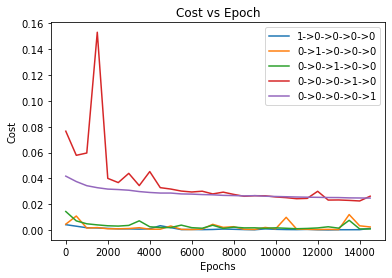

In [32]:
x = range(1,15001,500)

plt.plot(x,cost1, label='1->0->0->0->0')
plt.plot(x,cost2, label='0->1->0->0->0')
plt.plot(x,cost3, label='0->0->1->0->0')
plt.plot(x,cost4, label='0->0->0->1->0')
plt.plot(x,cost5, label='0->0->0->0->1')
#plt.plot(x,cost4, label='alpha = 40, beta = 0')

plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epoch')
plt.legend()
plt.show()